In [1]:
import os
os.chdir('..')

import networkx as nx
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from nn_homology import nn_graph

import persim # see persim.scikit-tda.org
from ripser import ripser # see ripser.scikit-tda.org

To generate the model used in this example, I ran:

`python main.py --arch_type fc1 --dataset mnist --prune_percent 90 --prune_iterations 2 --end_iter 20`

In [2]:
# Global-like variable definitions.
model_name = 'fc1'
dataset_name = 'mnist'
data_location = '../data' # location of training data (MNIST, FashionMNIST, CIFAR, etc.)
msk_pct = 90 # prune percentage for LT network
model_loc0 = 'saves/{}/{}/0_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, un-pruned model 
model_loc1 = 'saves/{}/{}/1_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, pruned model (after 1 prune iteration)

## Unpruned Model Homology

In [3]:
# load the model.
model = torch.load(model_loc0)

/home/schraterlab/anaconda3/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
param_info = [{'layer_type':'Linear', 'name': 'Linear1'},
            {'layer_type':'Linear', 'name': 'Linear2'},
            {'layer_type':'Linear', 'name': 'Linear3'}]

In [5]:
NNG = nn_graph.NNGraph()
G = NNG.parameter_graph(model, param_info, (1,1,28,28))

Layer: Linear1
Layer: Linear2
Layer: Linear3


In [6]:
# helper function for testing model, outputs accuracy
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [7]:
# Test to make sure model works.
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
testdataset = datasets.MNIST(data_location, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=0,drop_last=True)
criterion = torch.nn.CrossEntropyLoss()
print('Accuracy: {}'.format(test(model, test_loader, criterion)))

Accuracy: 97.09


In [8]:
# sanity check on model parameters
en = 784+300+100+10 # expected number of nodes given the architecture
ee = 300*784+100*300+10*100 # expected number of edges given the architecture
nn = G.number_of_nodes() # number of nodes in our computed networkx representation
ne = G.number_of_edges() # number of edges in our computed networkx representation

print('Expected Nodes: {} | Expected Edges: {}'.format(en,ee))
print('Number of Nodes: {}, {:.2f}% | Number of Edges: {}, {:.2f}%'.format(nn, nn/en*100,ne, ne/ee*100))

Expected Nodes: 1194 | Expected Edges: 266200
Number of Nodes: 1194, 100.00% | Number of Edges: 266200, 100.00%


In [9]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
rips = ripser(scipy.sparse.csr_matrix(NNG.get_adjacency()), distance_matrix=True, maxdim=1)
rips

{'dgms': [array([[0.        , 0.63228822],
         [0.        , 0.63501561],
         [0.        , 0.64318949],
         ...,
         [0.        , 1.        ],
         [0.        , 1.        ],
         [0.        ,        inf]]),
  array([[1.01782656,        inf],
         [1.01551247,        inf],
         [1.01226592,        inf],
         ...,
         [0.72559041,        inf],
         [0.723818  ,        inf],
         [0.71506083,        inf]])],
 'cocycles': [[], []],
 'num_edges': 266200,
 'dperm2all': <1194x1194 sparse matrix of type '<class 'numpy.float64'>'
 	with 532400 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([   0,    1,    2, ..., 1191, 1192, 1193]),
 'r_cover': 0.0}

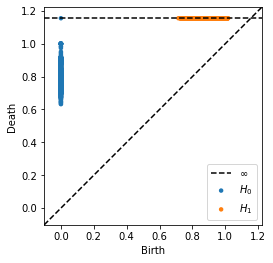

In [10]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips['dgms'])

## Pruned LT Homology

In [11]:
# load the LT model.
model_lt = torch.load(model_loc1)

/home/schraterlab/anaconda3/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [12]:
NNG.update_adjacency(model_lt)

In [13]:
# test this model's accuracy.
print('Accuracy: {}'.format(test(model_lt, test_loader, criterion)))

Accuracy: 96.65


In [14]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
rips_lt = ripser(scipy.sparse.csr_matrix(NNG.get_adjacency()), distance_matrix=True, maxdim=1)
rips_lt

{'dgms': [array([[0.        , 0.42750561],
         [0.        , 0.48036656],
         [0.        , 0.48292285],
         ...,
         [0.        , 1.        ],
         [0.        , 1.        ],
         [0.        ,        inf]]),
  array([[1.0107981 ,        inf],
         [1.0102582 ,        inf],
         [1.0095731 ,        inf],
         ...,
         [0.61315054,        inf],
         [0.60891283,        inf],
         [0.60113001,        inf]])],
 'cocycles': [[], []],
 'num_edges': 266200,
 'dperm2all': <1194x1194 sparse matrix of type '<class 'numpy.float64'>'
 	with 532400 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([   0,    1,    2, ..., 1191, 1192, 1193]),
 'r_cover': 0.0}

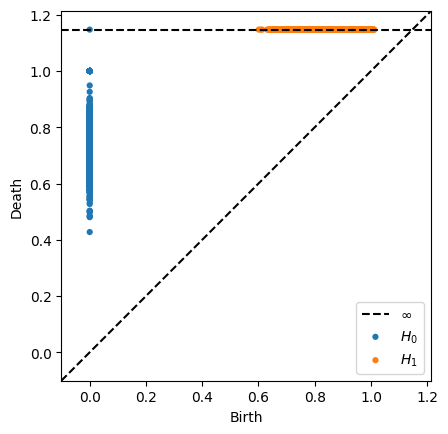

In [15]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips_lt['dgms'])

## Compare Networks

/home/schraterlab/anaconda3/lib/python3.8/site-packages/persim/bottleneck.py:53: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/home/schraterlab/anaconda3/lib/python3.8/site-packages/persim/bottleneck.py:63: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Bottleneck Distance: 0.2047826051712036


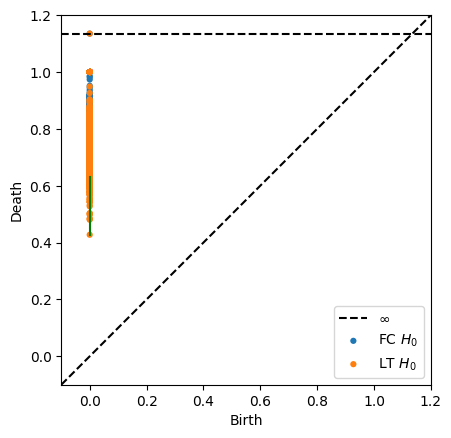

In [16]:
# compute the bottleneck distance between networks and plot the implicit matching. 
# bottleneck distance is defined as the distance between the farthest-apart matched points. 
# NOTE: the persim package ignores points at infinity, so this calculation still returns 
# a bounded result. Technically, the bottleneck distance between the two networks is \infty. 
distance_bottleneck, (matching, D) = persim.bottleneck(rips['dgms'][0], rips_lt['dgms'][0], matching=True)
persim.bottleneck_matching(rips['dgms'][0], rips_lt['dgms'][0], matching, D, labels=['FC $H_0$', 'LT $H_0$'])
print('Bottleneck Distance: {}'.format(distance_bottleneck))